# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix

# Plotting
sns.set()
%matplotlib inline

# Importing Data

In [2]:
# First number = subject
# Second number = run

# Stockpile the data
x_stock, x_time_stock, y_stock, y_time_stock = [], [], [], []
for subject in range(1,10):
    x_stock.append(sorted(glob(f'subject_00{subject}_0*__x.csv')))
    x_time_stock.append(sorted(glob(f'subject_00{subject}_0*__x_time.csv')))
    y_stock.append(sorted(glob(f'subject_00{subject}_0*__y.csv')))
    y_time_stock.append(sorted(glob(f'subject_00{subject}_0*__y_time.csv')))
for subject in range(3):
    x_stock.append(sorted(glob(f'subject_01{subject}_0*__x.csv')))
    x_time_stock.append(sorted(glob(f'subject_01{subject}_0*__x_time.csv')))
    y_time_stock.append(sorted(glob(f'subject_01{subject}_0*__y_time.csv')))
y_stock.pop()    # delete last row (it's empty)

# Flatten the stockpiles (2D to 1D)
x_stock = [item for sublist in x_stock for item in sublist]
x_time_stock = [item for sublist in x_time_stock for item in sublist]
y_stock = [item for sublist in y_stock for item in sublist]
y_time_stock = [item for sublist in y_time_stock for item in sublist]


# Data Preprocessing

In [3]:
def window_slicing(df):
    ''' Creating window of 4 sec reading for each prediction.
    At the end we loose 39 or 40 predictions (20 from the front and
    19 or 20 from the end) due to missing readings for the window.
    To mitigate that, inlude zeros in their place later. '''

    number_of_windows = int((len(df) - 160) / 4) + 1    # number of full windows in a sample list
    samples = np.zeros(160*number_of_windows*6).reshape(number_of_windows, 160, 6)    # samples, time steps per sample, features per time step
    start_index = 0     # where to start each window
    for i in range(number_of_windows):
        window = df[start_index:start_index+160]
        samples[i] = window
        start_index += 4    # move the window

    return samples

In [4]:
def cut_labels(x_windows, y):
    ''' Cutting the 20 first and
    19 or 20 last labels to align
    with x_windows. '''

    y = y[20:]   # cut the first 20 labels
    
    end = y.shape[0] - x_windows.shape[0]   # either 19 or 20
    y = y[:-end]    # cut the last 19 or 20 labels

    return y

In [5]:
def read_data_list(x_stock, y_stock):
    ''' Reads in and preprocesses data and keeps it in an array
    as a nested list of subjects. '''

    x_train, x_val, x_test, y_train, y_val = [], [], [], [], []
    counter = 0

    # Read x_train and y_train
    for file in x_stock[:27]:
        x = pd.read_csv(file, names=["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"])   # read a subject
        windows = window_slicing(x)    # cut it to windows
        x_train.append(windows)    # append to list of subjects

        y = pd.read_csv(y_stock[counter], names=["label"])   # read a subject
        cut = cut_labels(windows, y)    # cut the extra labels
        y_train.append(cut)    # append to list of subjects

        counter += 1    # increase the counter
    
    # Read x_val and y_val
    for file in x_stock[27:-4]:
        x = pd.read_csv(file, names=["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"])   # read a subject
        windows = window_slicing(x)    # cut it to windows
        x_val.append(windows)    # append to list of subjects

        y = pd.read_csv(y_stock[counter], names=["label"])   # read a subject
        cut = cut_labels(windows, y)    # cut the extra labels
        y_val.append(cut)    # append to list of subjects

        counter += 1    # increase the counter

    # Read x_test
    for file in x_stock[-4:]:
        x = pd.read_csv(file, names=["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"])   # read a subject
        windows = window_slicing(x)    # cut it to windows
        x_test.append(windows)    # append to list of subjects

    return x_train, x_val, x_test, y_train, y_val

In [6]:
def concat_data(x_train_subj, x_val_subj, x_test_subj, y_train_subj, y_val_subj):
    ''' Concatenates all data into respective
    x_train, x_val, x_test, y_train and y_val arrays. '''

    x_train, x_val, x_test, y_train, y_val = x_train_subj[0], x_val_subj[0], x_test_subj[0], y_train_subj[0], y_val_subj[0]   # add first subjects

    # Concatenate x_train and y_train
    for i in range(1, len(x_train_subj)):
        x_train = np.concatenate((x_train, x_train_subj[i]))
        y_train = np.concatenate((y_train, y_train_subj[i]))

    # Concatenate x_val and y_val
    for i in range(1, len(x_val_subj)):
        x_val = np.concatenate((x_val, x_val_subj[i]))
        y_val = np.concatenate((y_val, y_val_subj[i]))

    # Concatenate x_test
    for i in range(1, len(x_test_subj)):
        x_test = np.concatenate((x_test, x_test_subj[i]))

    return x_train, x_val, x_test, y_train, y_val

In [7]:
# Read data as subjects
x_train_subj, x_val_subj, x_test_subj, y_train_subj, y_val_subj = read_data_list(x_stock, y_stock)

In [8]:
# Concatinate the data
x_train, x_val, x_test, y_train, y_val = concat_data(x_train_subj, x_val_subj, x_test_subj, y_train_subj, y_val_subj)

### Standardize data

In [9]:
# Reshape data for standardizing
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], -1))
x_val_reshaped = np.reshape(x_val, (x_val.shape[0], -1))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], -1))

# Fit Scaler object
scalar = StandardScaler()
scalar.fit(x_train_reshaped)    # fit only the training data

# Standardize
x_train_stand_reshaped = scalar.transform(x_train_reshaped)
x_val_stand_reshaped = scalar.transform(x_val_reshaped)
x_test_stand_reshaped = scalar.transform(x_test_reshaped)

# Reshape back to window shape
x_train_stand = np.reshape(x_train_stand_reshaped, (x_train.shape[0], 160, 6))
x_val_stand = np.reshape(x_val_stand_reshaped, (x_val.shape[0], 160, 6))
x_test_stand = np.reshape(x_test_stand_reshaped, (x_test.shape[0], 160, 6))

# Model training and selection

In [10]:
def plot_history(history):
    ''' Function for plotting the training and validation history. '''
    
	# plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Training and validating the CNN model

In [11]:
print(f'x_train shape:', x_train.shape)
print(f'x_val shape:', x_val.shape)

print(f'y_train shape:', y_train.shape)
print(f'y_val shape:', y_val.shape)

x_train shape: (312454, 160, 6)
x_val shape: (21815, 160, 6)
y_train shape: (312454, 1)
y_val shape: (21815, 1)


### One-hot encoding

In [12]:
y_train_1H = to_categorical(y_train, num_classes=4)
y_val_1H = to_categorical(y_val, num_classes=4)

### CNN model

In [13]:
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train_1H.shape[1]

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 158, 64)           1216      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 156, 64)           12352     
_________________________________________________________________
dropout (Dropout)            (None, 156, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 78, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 4992)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               499300    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4

In [45]:
history = model.fit(x_train_stand, y_train_1H, epochs=3, batch_size=128, validation_data=(x_val_stand, y_val_1H))

Epoch 1/3
2442/2442 [==============================] - 152s 60ms/step - loss: 0.2796 - accuracy: 0.8992 - val_loss: 0.2543 - val_accuracy: 0.8999
Epoch 2/3
2442/2442 [==============================] - 145s 59ms/step - loss: 0.0969 - accuracy: 0.9661 - val_loss: 0.2040 - val_accuracy: 0.9327
Epoch 3/3
2442/2442 [==============================] - 145s 60ms/step - loss: 0.0752 - accuracy: 0.9730 - val_loss: 0.2175 - val_accuracy: 0.9311


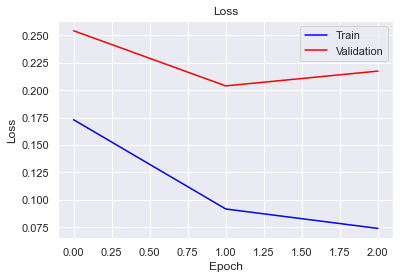

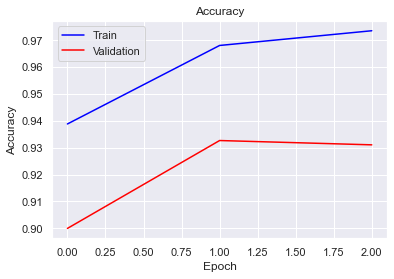

In [46]:
plot_history(history)

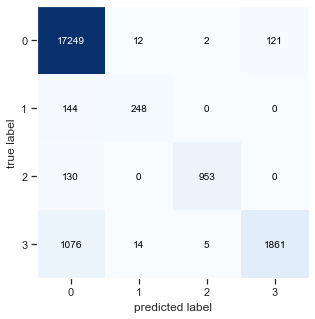

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     17384
           1       0.91      0.63      0.74       392
           2       0.99      0.88      0.93      1083
           3       0.94      0.63      0.75      2956

    accuracy                           0.93     21815
   macro avg       0.94      0.78      0.85     21815
weighted avg       0.93      0.93      0.93     21815



In [47]:
# Confusion Matrix
pred = model.predict(x_val_stand)
pred = np.argmax(pred, axis = 1)  # transform prediction into 0-3 labels
y_true = y_val

CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 5))
plt.show()

print(classification_report(y_true, pred))

## Hyperparameter tuning

### Defining the final model for optimization

In [14]:
def define_final_model(lr=0.001):
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### Creating an instance of the model

In [15]:
final_model = KerasClassifier(build_fn=define_final_model)

### Defining the learning rates for the grid search

In [16]:
lr = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
param_grid = dict(lr=lr)

### Grid Search

In [17]:
grid = GridSearchCV(estimator=final_model, param_grid=param_grid, cv=4, verbose=3)
grid_result = grid.fit(x_train_stand, y_train_1H)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
2442/2442 [==============================] - 7s 3ms/step - loss: 0.8791 - accuracy: 0.7516
[CV 1/4] END .........................................lr=0.1; total time= 2.9min
2442/2442 [==============================] - 8s 3ms/step - loss: 0.8585 - accuracy: 0.6869
[CV 2/4] END .........................................lr=0.1; total time= 2.6min
2442/2442 [==============================] - 7s 3ms/step - loss: 0.6940 - accuracy: 0.8074
[CV 3/4] END .........................................lr=0.1; total time= 2.4min
2442/2442 [==============================] - 7s 3ms/step - loss: 0.8131 - accuracy: 0.7396
[CV 4/4] END .........................................lr=0.1; total time= 2.4min
2442/2442 [==============================] - 8s 3ms/step - loss: 0.8736 - accuracy: 0.7516
[CV 1/4] END ........................................lr=0.05; total time= 2.6min
2442/2442 [==============================] - 7s 3ms/step - loss: 0.8700 - accura

### The most optimal learning rate

In [18]:
print(f'The best score of {grid_result.best_score_} corresponds to the learning rate of {grid_result.best_params_}.')

The best score of 0.8783150166273117 corresponds to the learning rate of {'lr': 0.001}.


In [20]:
grid_result.cv_results_

{'mean_fit_time': array([148.05057096, 135.73747504, 133.48951775, 132.89052874,
        145.63091743, 142.53194606, 149.97126025]),
 'std_fit_time': array([10.8354807 ,  6.96287419,  5.11411798,  5.26633852,  8.01521458,
         3.21975576, 12.36708551]),
 'mean_score_time': array([8.29774135, 8.57434106, 7.61385298, 8.16273552, 8.22869283,
        7.94345969, 8.21432471]),
 'std_score_time': array([0.96778624, 1.08917954, 0.35908647, 1.57035852, 0.27648545,
        0.26346649, 0.90252573]),
 'param_lr': masked_array(data=[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lr': 0.1},
  {'lr': 0.05},
  {'lr': 0.01},
  {'lr': 0.005},
  {'lr': 0.001},
  {'lr': 0.0005},
  {'lr': 0.0001}],
 'split0_test_score': array([0.75160664, 0.75160664, 0.75160664, 0.91933584, 0.87739712,
        0.94406891, 0.88302994]),
 'split1_test_score': array([0.68685514, 0.68685

# The final prediction (using the actual test set).

In [51]:
pred_09 = model.predict(x_test_stand[:9458])
pred_09_final = np.argmax(pred_09, axis = 1)  # transform prediction into 0-3 labels
pred_10 = model.predict(x_test_stand[9458:21689])
pred_10_final = np.argmax(pred_10, axis = 1)  # transform prediction into 0-3 labels
pred_11 = model.predict(x_test_stand[21689:34590])
pred_11_final = np.argmax(pred_11, axis = 1)  # transform prediction into 0-3 labels
pred_12 = model.predict(x_test_stand[34590:])
pred_12_final = np.argmax(pred_12, axis = 1)  # transform prediction into 0-3 labels

In [52]:
print(f"09:", len(pred_09_final))   # should be 9498
print(f"10:", len(pred_10_final))   # should be 12270
print(f"11:", len(pred_11_final))   # should be 12940
print(f"12:", len(pred_12_final))   # should be 11330

09: 9458
10: 12231
11: 12901
12: 11290


### Padding the missing predictions with zeros

In [53]:
pred_09_final = np.concatenate((np.zeros(20), pred_09_final, np.zeros(20)))
pred_09_final.shape

(9498,)

In [54]:
pred_10_final = np.concatenate((np.zeros(20), pred_10_final, np.zeros(19)))
pred_10_final.shape

(12270,)

In [55]:
pred_11_final = np.concatenate((np.zeros(20), pred_11_final, np.zeros(19)))
pred_11_final.shape

(12940,)

In [56]:
pred_12_final = np.concatenate((np.zeros(20), pred_12_final, np.zeros(20)))
pred_12_final.shape

(11330,)

### Output the prediction to 4 separate csv files.

In [57]:
pd.DataFrame(pred_09_final).to_csv('subject_009_01__y_prediction.csv', index = False, header = None)
pd.DataFrame(pred_10_final).to_csv('subject_010_01__y_prediction.csv', index = False, header = None)
pd.DataFrame(pred_11_final).to_csv('subject_011_01__y_prediction.csv', index = False, header = None)
pd.DataFrame(pred_12_final).to_csv('subject_012_01__y_prediction.csv', index = False, header = None)